In [3]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
# from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier

# import optuna 

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/PS-S3/Ep7/train.csv'
file_key_2 = 'Tabular-Playground-Series/PS-S3/Ep7/test.csv'
file_key_3 = 'Tabular-Playground-Series/PS-S3/Ep7/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

# train['low_price_flag'] = np.where(train['avg_price_per_room'] < 30, 1, 0)
train['total_guests'] = train['no_of_adults'] + train['no_of_children']
train['stay_length'] = train['no_of_weekend_nights'] + train['no_of_week_nights']
train['stay_during_weekend'] = np.where(train['no_of_weekend_nights'] > 0, 1, 0)
train['quarter_1'] = np.where(train['arrival_month'] <= 3, 1, 0)
train['quarter_2'] = np.where(((train['arrival_month'] >= 4) & (train['arrival_month'] <= 6)), 1, 0)
train['quarter_3'] = np.where(((train['arrival_month'] >= 7) & (train['arrival_month'] <= 9)), 1, 0)

# test['low_price_flag'] = np.where(test['avg_price_per_room'] < 30, 1, 0)
test['total_guests'] = test['no_of_adults'] + test['no_of_children']
test['stay_length'] = test['no_of_weekend_nights'] + test['no_of_week_nights']
test['stay_during_weekend'] = np.where(test['no_of_weekend_nights'] > 0, 1, 0)
test['quarter_1'] = np.where(test['arrival_month'] <= 3, 1, 0)
test['quarter_2'] = np.where(((test['arrival_month'] >= 4) & (test['arrival_month'] <= 6)), 1, 0)
test['quarter_3'] = np.where(((test['arrival_month'] >= 7) & (test['arrival_month'] <= 9)), 1, 0)

In [4]:
train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,total_guests,stay_length,stay_during_weekend,quarter_1,quarter_2,quarter_3
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0,2,2,0,1,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0,2,3,1,0,0,1
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0,2,1,0,0,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0,1,2,0,0,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1,2,1,1,0,0,0


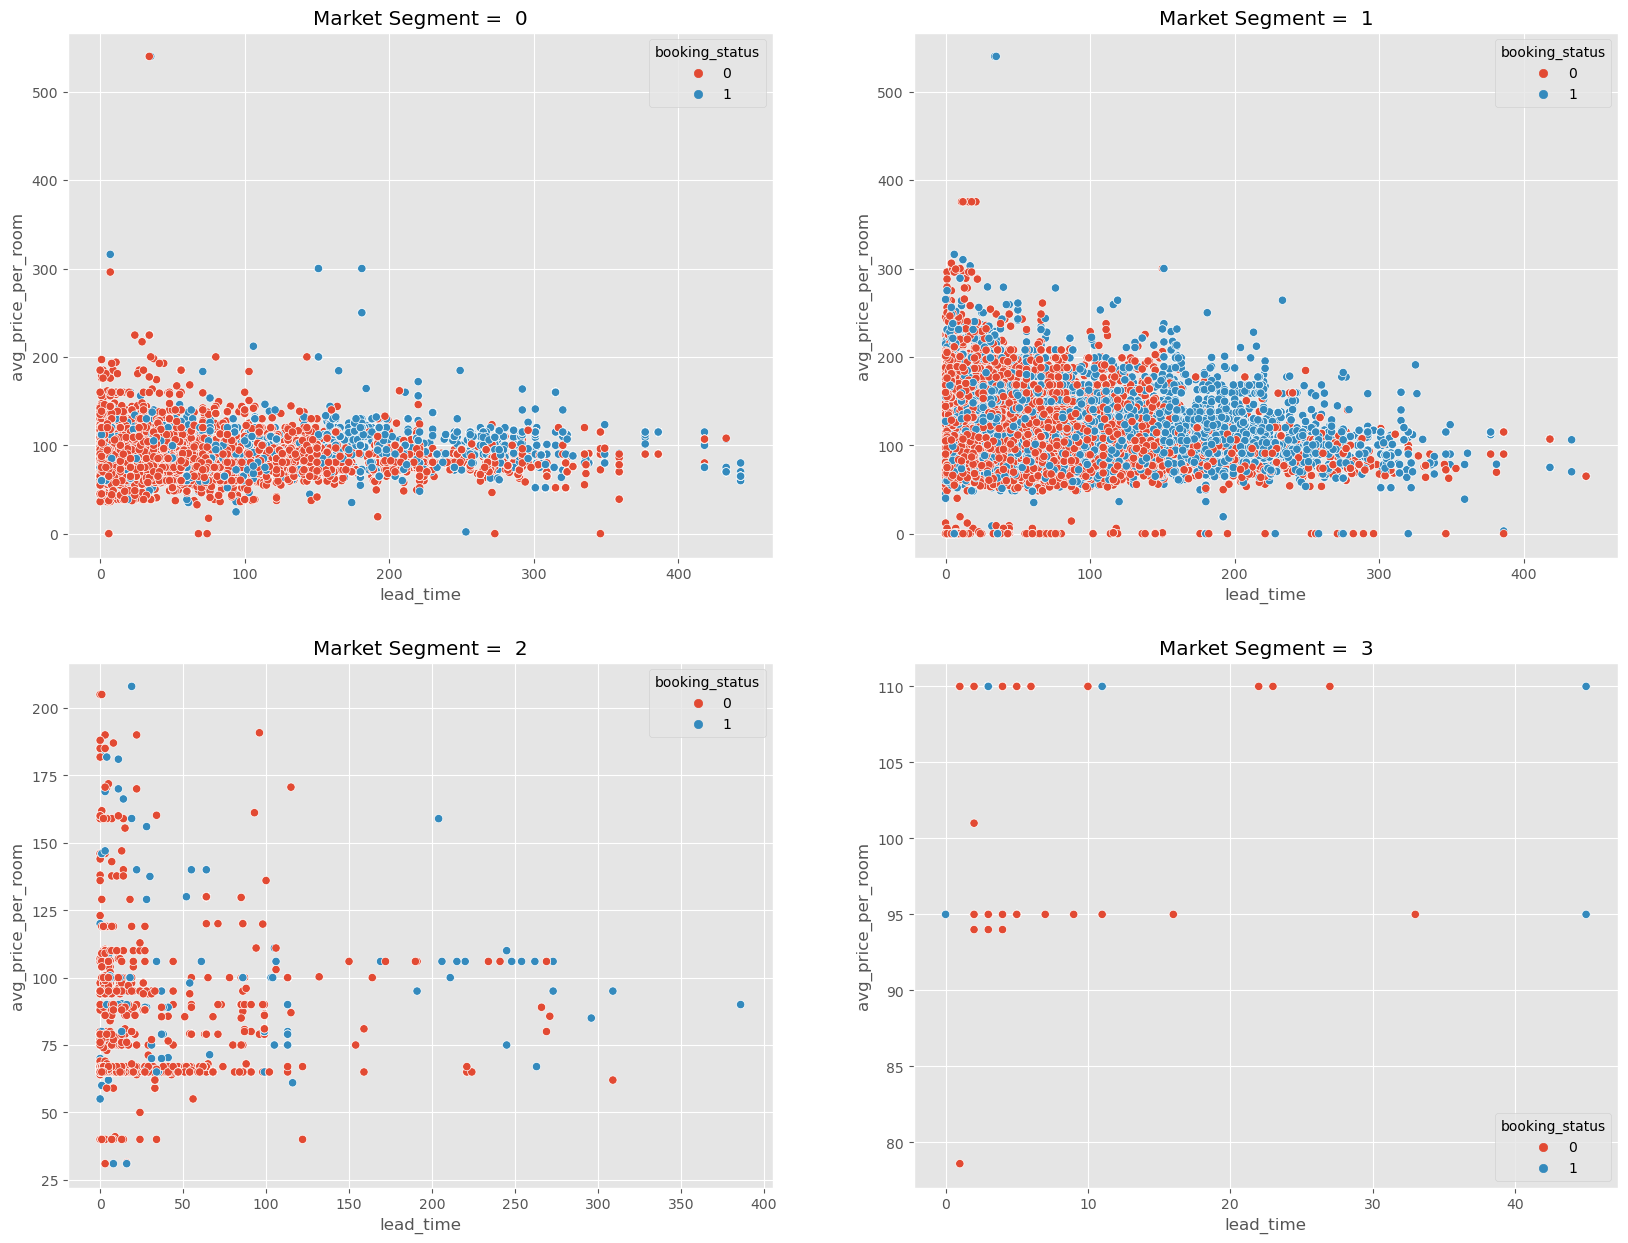

In [9]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))

sns.scatterplot(ax = axes[0, 0], x = 'lead_time', y = 'avg_price_per_room', hue = 'booking_status', data = train[train['market_segment_type'] == 0]).set_title('Market Segment =  0')
sns.scatterplot(ax = axes[0, 1], x = 'lead_time', y = 'avg_price_per_room', hue = 'booking_status', data = train[train['market_segment_type'] == 1]).set_title('Market Segment =  1')
sns.scatterplot(ax = axes[1, 0], x = 'lead_time', y = 'avg_price_per_room', hue = 'booking_status', data = train[train['market_segment_type'] == 2]).set_title('Market Segment =  2')
sns.scatterplot(ax = axes[1, 1], x = 'lead_time', y = 'avg_price_per_room', hue = 'booking_status', data = train[train['market_segment_type'] == 3]).set_title('Market Segment =  3');

In [10]:
data1 = train[train['market_segment_type'] == 0].reset_index(drop = True)
data1.describe()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,total_guests,stay_length,stay_during_weekend
count,14306.000000,14306.000000,14306.000000,14306.000000,14306.000000,14306.000000,14306.000000,14306.000000,14306.000000,14306.000000,14306.000000,14306.000000,14306.0,14306.000000,14306.000000,14306.000000,14306.000000,14306.000000,14306.000000,14306.000000,14306.000000,14306.000000
mean,20984.450440,1.813854,0.020062,0.824759,2.255837,0.310010,0.004544,0.110513,98.670278,2017.735845,7.693555,15.711520,0.0,0.005732,0.006291,0.015518,87.839591,0.214036,0.225989,1.833916,3.080596,0.553125
std,12156.223749,0.451592,0.146554,0.837335,1.167414,0.712896,0.067255,0.425529,88.336662,0.440898,3.049774,8.760906,0.0,0.075494,0.174067,0.631491,24.249249,0.472570,0.418247,0.477921,1.437844,0.497187
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,10497.250000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,34.000000,2017.000000,5.000000,8.000000,0.0,0.000000,0.000000,0.000000,72.250000,0.000000,0.000000,2.000000,2.000000,0.000000
50%,20962.000000,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,73.000000,2018.000000,9.000000,16.000000,0.0,0.000000,0.000000,0.000000,85.000000,0.000000,0.000000,2.000000,3.000000,1.000000
75%,31532.250000,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,141.000000,2018.000000,10.000000,23.000000,0.0,0.000000,0.000000,0.000000,101.000000,0.000000,0.000000,2.000000,4.000000,1.000000
max,42099.000000,3.000000,2.000000,7.000000,11.000000,2.000000,1.000000,5.000000,443.000000,2018.000000,12.000000,31.000000,0.0,1.000000,13.000000,46.000000,540.000000,4.000000,1.000000,4.000000,16.000000,1.000000


In [12]:
data1['room_type_reserved'].value_counts()

0    13068
1     1060
2       93
4       72
3        9
5        4
Name: room_type_reserved, dtype: int64

In [13]:
data1.groupby('room_type_reserved')['booking_status'].mean()

room_type_reserved
0    0.240894
1    0.047170
2    0.215054
3    0.222222
4    0.180556
5    0.000000
Name: booking_status, dtype: float64

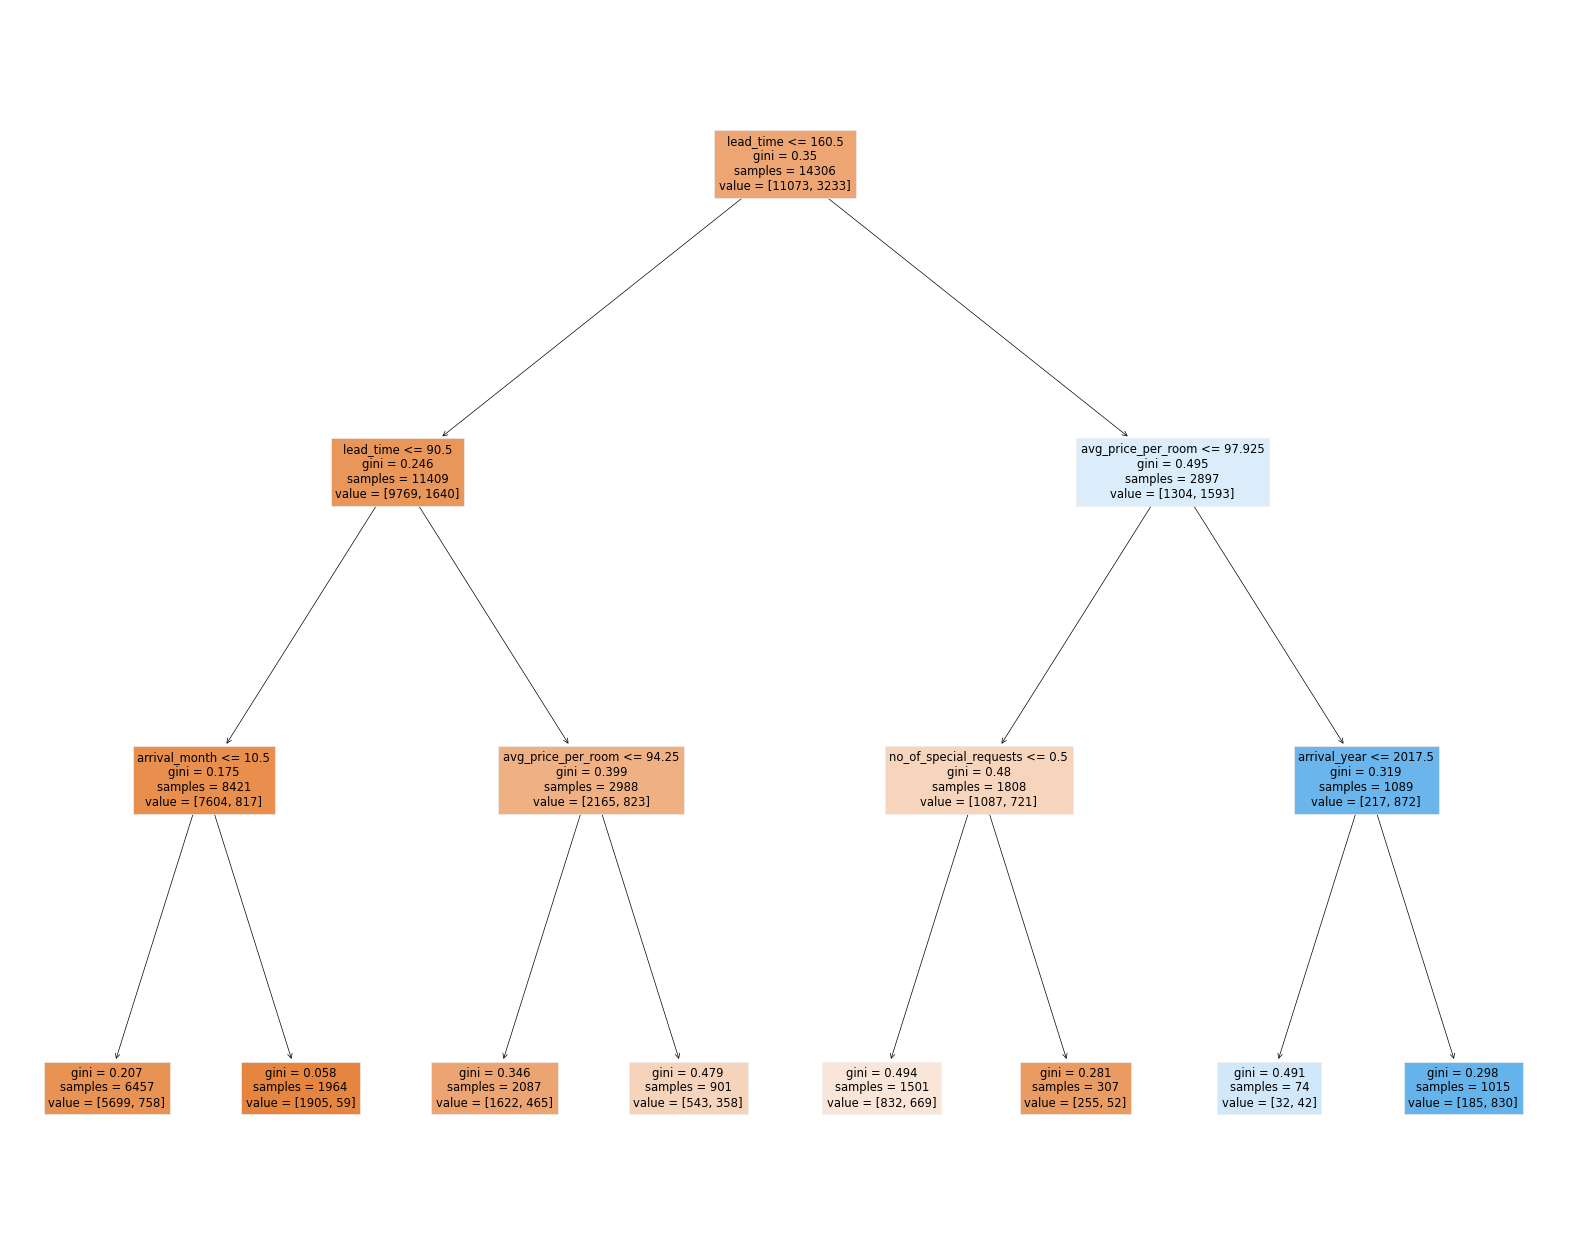

In [11]:
## Defining the input and target variables
X = data1.drop(columns = ['id', 'booking_status'], axis = 1)
Y = data1['booking_status']

## Building a decision tree model with max depth = 3 on the train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X, Y)

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 16))
plot_tree(tree_md, feature_names = X.columns, filled = True);

In [14]:
data2 = train[train['market_segment_type'] == 1].reset_index(drop = True)
data2.describe()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,total_guests,stay_length,stay_during_weekend
count,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.0,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.000000,25885.00000,25885.000000,25885.000000
mean,21070.668882,2.031254,0.214796,0.946494,2.537222,0.214062,0.029477,0.592351,112.531196,2017.926946,7.564188,16.019741,1.0,0.003863,0.009504,0.014255,116.790028,0.779486,0.505466,2.24605,3.483716,0.595094
std,12153.401825,0.516372,0.544416,0.906136,1.529514,0.517014,0.169141,0.901339,75.257500,0.260230,2.634708,8.989483,0.0,0.062036,0.301163,0.469258,37.013698,0.838839,0.499980,0.70184,1.950421,0.490883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,10499.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,52.000000,2018.000000,6.000000,8.000000,1.0,0.000000,0.000000,0.000000,90.950000,0.000000,0.000000,2.00000,2.000000,0.000000
50%,21062.000000,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,109.000000,2018.000000,8.000000,16.000000,1.0,0.000000,0.000000,0.000000,111.350000,1.000000,1.000000,2.00000,3.000000,1.000000
75%,31580.000000,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,1.000000,162.000000,2018.000000,10.000000,24.000000,1.0,0.000000,0.000000,0.000000,137.700000,1.000000,1.000000,3.00000,4.000000,1.000000
max,42095.000000,4.000000,9.000000,6.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,1.0,1.000000,11.000000,46.000000,540.000000,5.000000,1.000000,11.00000,23.000000,1.000000


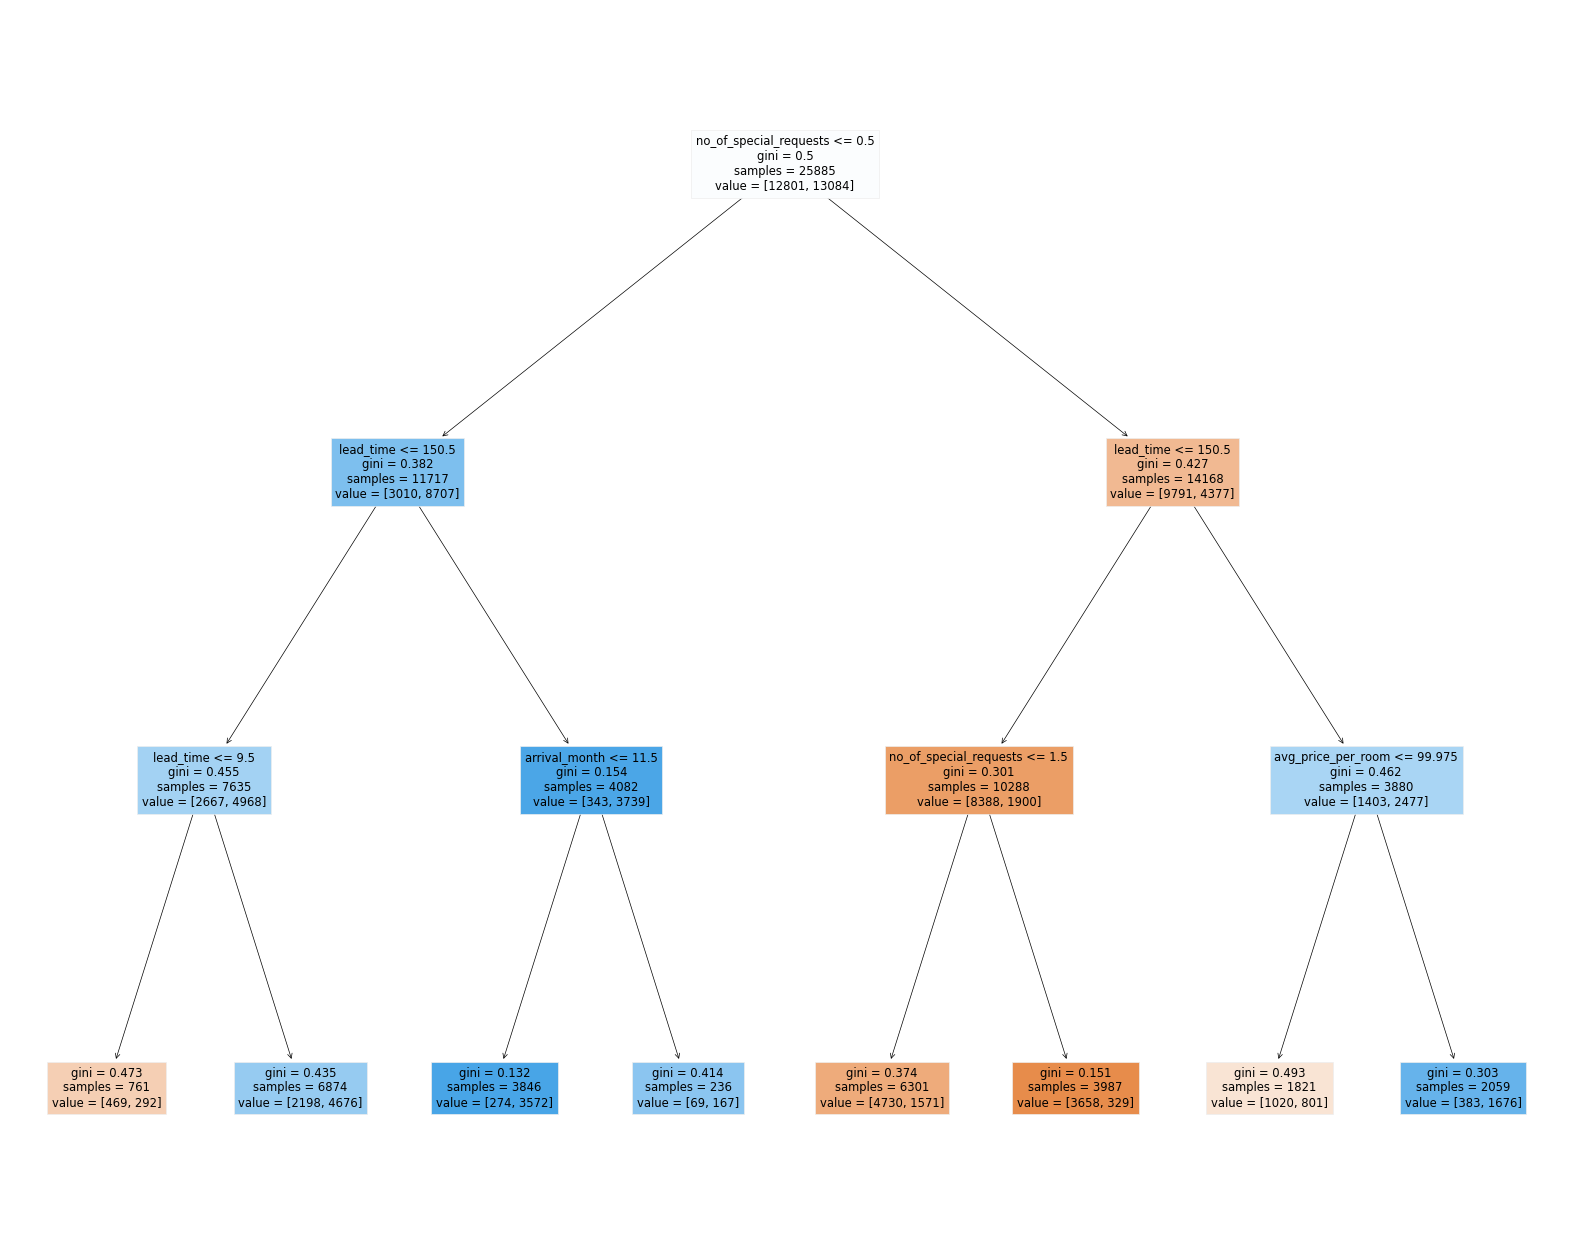

In [16]:
## Defining the input and target variables
X = data2.drop(columns = ['id', 'booking_status'], axis = 1)
Y = data2['booking_status']

## Building a decision tree model with max depth = 3 on the train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X, Y)

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 16))
plot_tree(tree_md, feature_names = X.columns, filled = True);

In [17]:
train['market_segment_type'].value_counts()

1    25885
0    14306
2     1384
4      442
3       83
Name: market_segment_type, dtype: int64

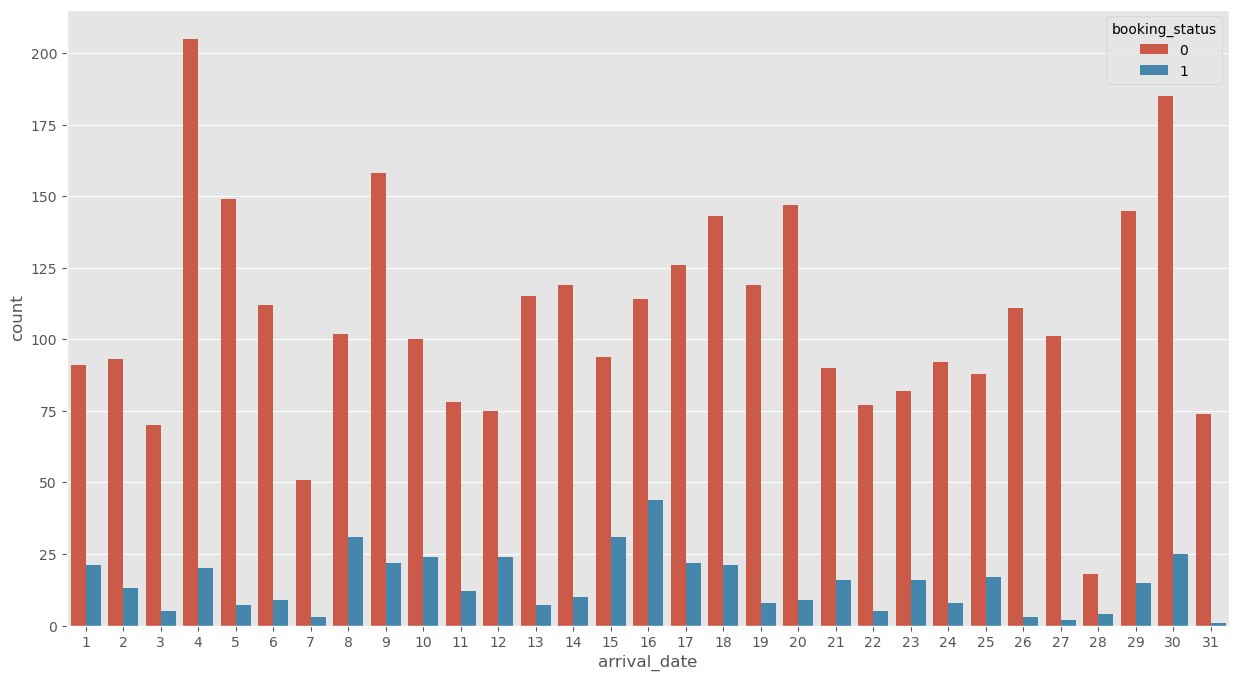

In [23]:
plt.figure(figsize = (15, 8))
sns.countplot(x = 'arrival_date', hue = 'booking_status', data = data1[data1['arrival_year'] == 2017]);

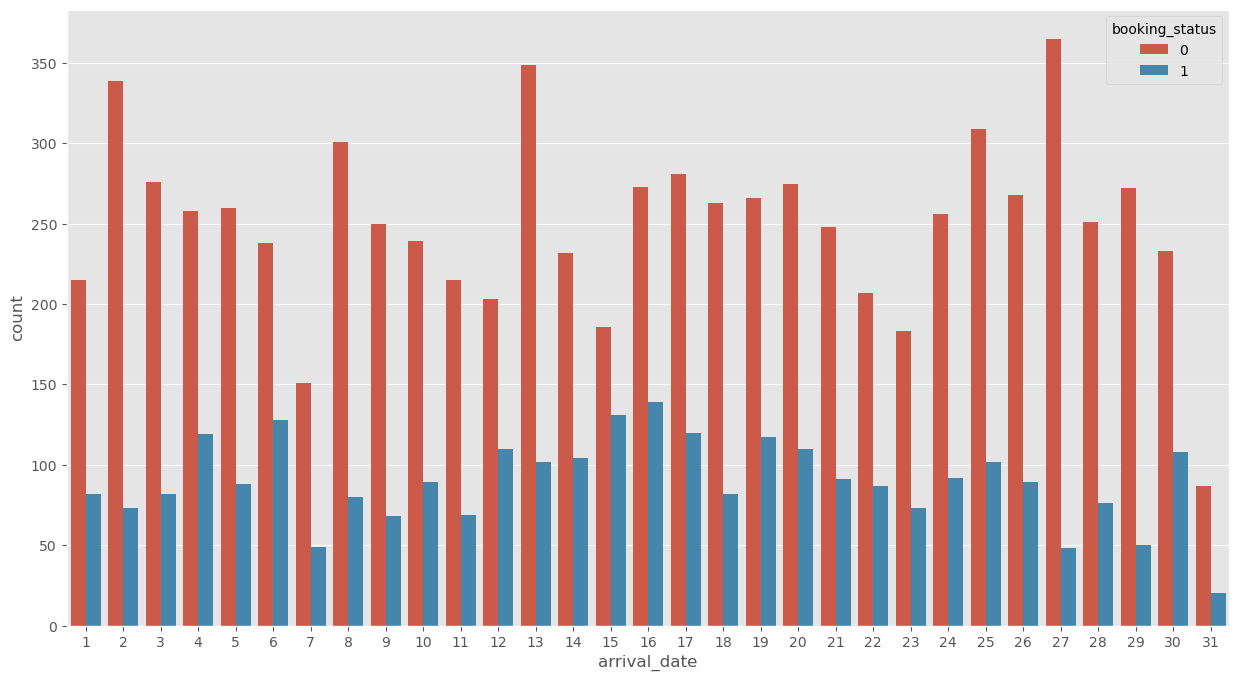

In [24]:
plt.figure(figsize = (15, 8))
sns.countplot(x = 'arrival_date', hue = 'booking_status', data = data1[data1['arrival_year'] == 2018]);

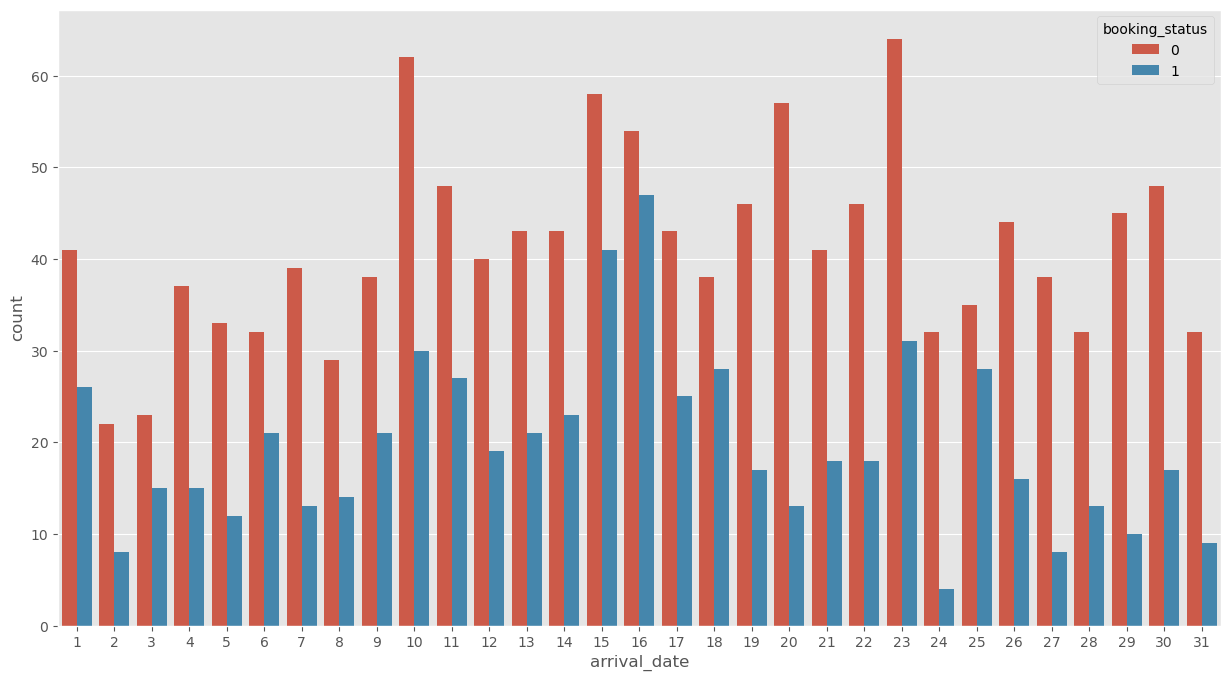

In [22]:
plt.figure(figsize = (15, 8))
sns.countplot(x = 'arrival_date', hue = 'booking_status', data = data2[data2['arrival_year'] == 2017]);

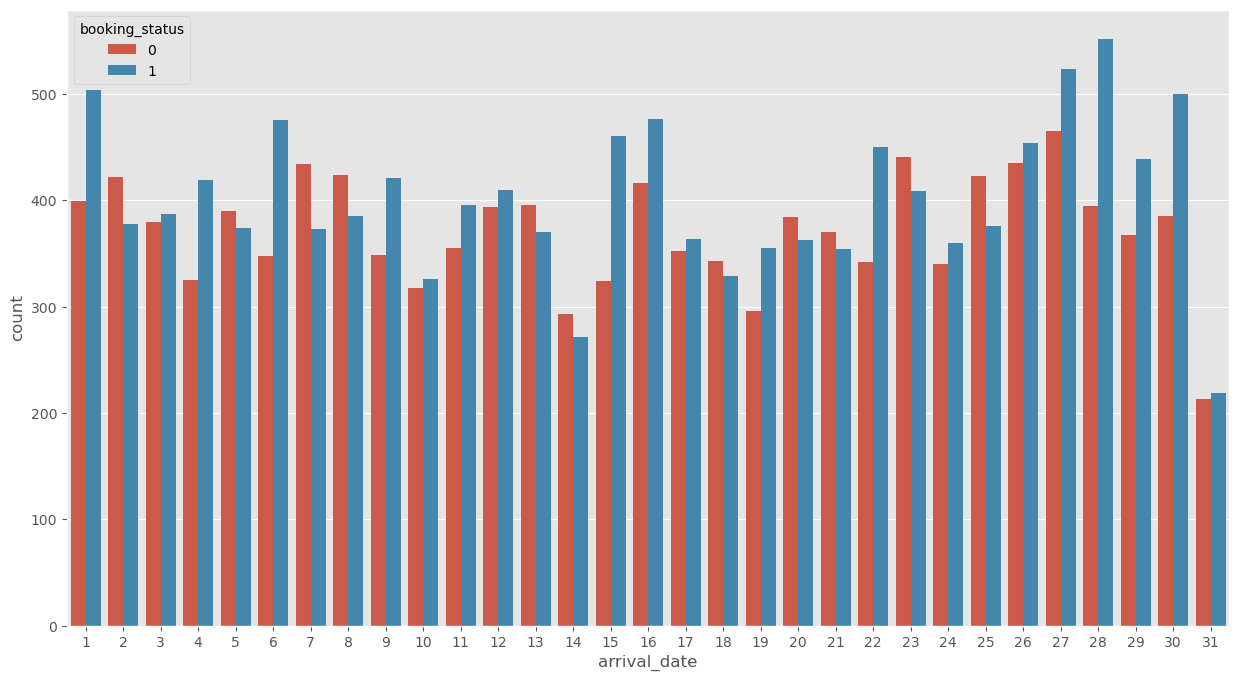

In [25]:
plt.figure(figsize = (15, 8))
sns.countplot(x = 'arrival_date', hue = 'booking_status', data = data2[data2['arrival_year'] == 2018]);